In [83]:
import pandas as pd
import json
import ast
import warnings
from io import StringIO
import hashlib
import matplotlib.pyplot as plt

from typing import List, Dict
import base64, csv

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.express as px

warnings.filterwarnings('ignore')

In [ ]:
%pip install matplotlib

In [84]:
def showPie(columna):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > 15:
    count_values = count_values.iloc[0:15]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

def concatenar(data_1, data_2,  axis=1):
  return pd.concat([data_1, data_2], axis=axis)

def contar_nulos(data):
  return data.isna().sum()

def mapear(columna: pd.Series, mapa={'NO': 0, 'SI':1}):
  return columna.map(mapa)

def showPiePx(columna, max=15):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})
  fig = px.pie(datos, values='ocurrencia', names='valor', title=columna.name)
  fig.update_traces(textposition='outside', textinfo='percent+label')
  fig.show()

In [85]:
URL_STEAM_GAMES = 'datasets/output_steam_games.json'
URL_USERS_ITEMS = 'datasets/australian_users_items.json'
URL_USERS_REVIEWS = 'datasets/australian_user_reviews.json'

In [86]:
df_games_all = pd.read_json(URL_STEAM_GAMES, lines=True)

In [87]:
df_games_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 11.9+ MB


1. Limpiamos filas con valores todos nulos


In [88]:
df_games = df_games_all[df_games_all.isna().sum(axis=1) != 13]

In [89]:
len(df_games)

32135

Verificamos duplicados

In [115]:
df_games['hash'] = df_games.apply(lambda row: hashlib.md5(row.astype(str).values.tobytes()).hexdigest(), axis=1)

In [134]:
df_games[df_games['hash'].duplicated()]

,publisher,genres,app_name,release_date,tags,specs,price,early_access,id,developer,hash


In [92]:
df_games = df_games.drop('hash', axis=1)

In [101]:
df_games[df_games.app_name.isna()]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
90890,None,"[Action, Indie]",None,None,http://store.steampowered.com/app/317160/_/,2014-08-26,"[Action, Indie]",http://steamcommunity.com/app/317160/reviews/?...,"[Single-player, Game demo]",None,0.0,317160.0,None


In [100]:
try:
    df_games = df_games.drop(88384, axis=0)
except:
    pass

2. Reseteamos el index

In [106]:
df_games.loc[90890, 'app_name'] = 'Duet'
df_games.loc[90890]

publisher                                                    None
genres                                            [Action, Indie]
app_name                                                     Duet
title                                                        None
url                   http://store.steampowered.com/app/317160/_/
release_date                                           2014-08-26
tags                                              [Action, Indie]
reviews_url     http://steamcommunity.com/app/317160/reviews/?...
specs                                  [Single-player, Game demo]
price                                                        None
early_access                                                  0.0
id                                                       317160.0
developer                                                    None
Name: 90890, dtype: object

In [107]:
df_games = df_games.reset_index()
# df_games = df_games.drop('index', axis=1);

In [108]:
# df_games = df_games.drop('level_0', axis=1);
df_games = df_games.drop('index', axis=1);

In [109]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32134 entries, 0 to 32133
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32134 non-null  object 
 3   title         30085 non-null  object 
 4   url           32134 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30757 non-null  object 
 10  early_access  32134 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 3.2+ MB


3. Eliminamos columnas consideradas innecesarias para el análisis

In [110]:
df_games = df_games.drop(['url', 'reviews_url', 'title'], axis=1)

In [111]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32134 entries, 0 to 32133
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32134 non-null  object 
 3   release_date  30068 non-null  object 
 4   tags          31972 non-null  object 
 5   specs         31465 non-null  object 
 6   price         30757 non-null  object 
 7   early_access  32134 non-null  float64
 8   id            32133 non-null  float64
 9   developer     28836 non-null  object 
dtypes: float64(2), object(8)
memory usage: 2.5+ MB


4. Buscamos solucionar valores nulos en el id, con el fin de utilizarlo como identificador del juego

In [122]:
df_games[df_games.id.isna()]

,publisher,genres,app_name,release_date,tags,specs,price,early_access,id,developer,hash


In [120]:
# Vemos que la fila 74 tiene datos nulos y la 30961 tiene el id en el campo URL (de algo sirvió)

# df_games.drop(74,inplace=True)
# df_games.drop(90890, inplace=True)
# df_games.loc[30960,'id'] = 200260
# 

In [23]:
# df_games.loc[90890, 'app_name'] = 'Duet'

In [121]:
df_games[df_games.id.isna()]

,publisher,genres,app_name,release_date,tags,specs,price,early_access,id,developer,hash


In [132]:
df_games.id.value_counts()

id
761140.0    1
530200.0    1
462680.0    1
518690.0    1
513460.0    1
           ..
676060.0    1
494160.0    1
215280.0    1
667090.0    1
681550.0    1
Name: count, Length: 32132, dtype: int64

In [135]:
df_games.query("id == 200260.0")

,publisher,genres,app_name,release_date,tags,specs,price,early_access,id,developer,hash
1067,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,0.0,200260.0,"Rocksteady Studios,Feral Interactive (Mac)",9c9c94c4cf39d5f644dcb7f30bb95061


In [131]:
df_games.drop([14572,  30960], axis=0, inplace=True)

In [126]:
df_games['hash'] = df_games.apply(lambda row: hashlib.md5(row.astype(str).values.tobytes()).hexdigest(), axis=1)

5. Trabajamos las columnas

In [136]:
df_games['id'] =df_games['id'].astype('int').values

df_games.early_access = df_games.early_access.astype('bool').values

In [137]:
def isnumber(x):
    try:
        x = float(x)
        return x
    except:
        return 0

In [138]:
df_games.price = df_games.price.apply(isnumber)

In [139]:
df_games['genres'].to_csv('generos.csv', index=False)

In [140]:
sin_genero = df_games.genres.isna()

In [141]:
df_games.loc[sin_genero, 'genres'] = df_games.loc[sin_genero, 'tags']

In [142]:
df_games.loc[sin_genero, 'genres'] = '[\'Action\']'

In [143]:
df_games[sin_genero]

,publisher,genres,app_name,release_date,tags,specs,price,early_access,id,developer,hash
4,None,['Action'],Log Challenge,None,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,False,773570,None,7c339ef9bcbddd55e9bb068d229f8e95
11,None,['Action'],Icarus Six Sixty Six,None,[Casual],"[Single-player, HTC Vive, Tracked Motion Contr...",0.00,False,724910,None,ca84206a8d1cbd328b91863915ead711
19,None,['Action'],After Life VR,None,"[Early Access, Indie, VR]","[Single-player, HTC Vive, Tracked Motion Contr...",4.99,True,772590,None,4a398f300221e7abd65af5d2c5d4ee66
20,None,['Action'],Kitty Hawk,None,"[Early Access, Action, Adventure, Indie, Casual]","[Single-player, Steam Leaderboards, HTC Vive, ...",2.99,True,640250,None,a05dd474efce0c6eae80e94b3b519585
22,None,['Action'],Mortars VR,None,"[Early Access, Strategy, Action, Indie, Casual...","[Single-player, Multi-player, Online Multi-Pla...",0.99,True,711440,None,463b15b237af899af77dad052a4fa415
...,...,...,...,...,...,...,...,...,...,...,...
32117,None,['Action'],Robotpencil Presents: Exercise: Brushwork,2018-01-03,"[Design & Illustration, Tutorial]",None,3.99,False,775640,None,e3a172f6cdb46e53308931e098825320
32118,None,['Action'],Robotpencil Presents: Creative Composition,2018-01-03,"[Design & Illustration, Tutorial]",None,3.99,False,777930,None,ddecb4580202ea03af8292594a9a264d
32119,None,['Action'],The Gamble House,2016-11-19,[Movie],[Captions available],4.99,False,775370,None,37c4d28f736868f9ba2d344e88e0bf18
32120,None,['Action'],Kalen Chock Presents: 2017 Free Tutorial,2018-01-03,"[Design & Illustration, Tutorial]",None,0.00,False,777950,None,920db41162077e3b9221c7c7122ca3c9


In [144]:
type(df_games.iloc[31324].genres)

list

In [145]:
# Conjunto de géneros
set_genres = set()

In [146]:
# llenamos el conjunto

for i in df_games.index:
   try:
      for g in df_games.loc[i].genres:
         try:
            set_genres.add(g)
         except:
            pass
      for g in df_games.loc[i].tags:
         try:
            set_genres.add(g)
         except:
            pass
   except:
      pass

In [147]:
len(set_genres)

351

In [148]:
pd.Series(list(set_genres)).to_csv('indiv_genres.cvs', index=False)

Veamos los géneros por juego

In [149]:
lista_juegos_generos = []

for i in df_games.index:
   try:
      if df_games.loc[i].genres == '[\'Action\']':
         lista_eval = ast.literal_eval(df_games.loc[i].genres)
      else:
         lista_eval = df_games.loc[i].genres
      
      for g in lista_eval:
         try:
            id_juego =  df_games.loc[i].id
            tupla = (id_juego, g)            
            lista_juegos_generos.append(tupla)
         except:
            pass
   except:
      pass

In [150]:
juego_genero = pd.DataFrame(lista_juegos_generos, columns=['id_juego', 'genero'])

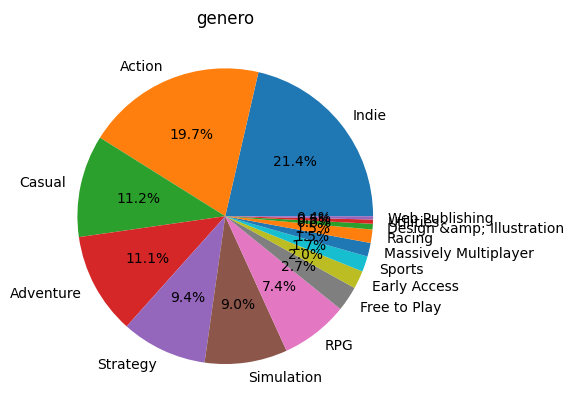

In [151]:
showPie(juego_genero.genero)

In [152]:
showPiePx(juego_genero.genero)

In [153]:
df_games[df_games.id == 681550]

,publisher,genres,app_name,release_date,tags,specs,price,early_access,id,developer,hash
32133,None,['Action'],Maze Run VR,None,"[Early Access, Adventure, Indie, Action, Simul...","[Single-player, Stats, Steam Leaderboards, HTC...",4.99,True,681550,None,20d88248f6fb22a86631aaf14184c4d3


In [154]:
juego_genero

,id_juego,genero
0,761140,Action
1,761140,Casual
2,761140,Indie
3,761140,Simulation
4,761140,Strategy
...,...,...
74828,610660,Racing
74829,610660,Simulation
74830,658870,Casual
74831,658870,Indie


In [155]:
juegos_sin_indie= juego_genero[~juego_genero.genero.isin(['Indie','Casual','Free to Play','Early Access','Massively Multiplayer'])]

juegos_sin_indie

,id_juego,genero
0,761140,Action
3,761140,Simulation
4,761140,Strategy
7,643980,RPG
8,643980,Strategy
...,...,...
74823,773640,Strategy
74826,733530,Strategy
74828,610660,Racing
74829,610660,Simulation


In [156]:
showPiePx(juegos_sin_indie.genero, max=8)

In [150]:
juegos_sin_indie.genero.value_counts().to_clipboard()

In [159]:
lista = juego_genero.query("genero == 'Casual'").id_juego.tolist()

In [160]:
df_games[df_games.id.isin(lista)]

,publisher,genres,app_name,release_date,tags,specs,price,early_access,id,developer,hash
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,False,761140,Kotoshiro,1310a32c3d59ced10ac59bacd3c918c7
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",0.00,False,670290,Poolians.com,e6163434bcfcf34f5d7cb4eec308a3fa
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",[Single-player],0.99,False,767400,彼岸领域,14a4a588371680c5224d3aceebbe1999
9,RewindApp,"[Casual, Indie, Racing, Simulation]",Race,2018-01-04,"[Indie, Casual, Simulation, Racing]","[Single-player, Multi-player, Partial Controll...",0.00,False,768800,RewindApp,2473bcf4eac8acda5bbdde417d533be9
12,Stegalosaurus Game Development,"[Action, Adventure, Casual, Indie, RPG]",Army of Tentacles: (Not) A Cthulhu Dating Sim:...,2018-01-04,"[Action, Adventure, RPG, Indie, Casual]","[Single-player, Steam Achievements]",10.99,False,770380,Stegalosaurus Game Development,a729776c01556ee63500092f09a51379
...,...,...,...,...,...,...,...,...,...,...,...
32127,Riviysky,"[Casual, Indie]",BAE 2,2018-01-04,"[Indie, Casual]",[Single-player],0.00,False,769330,Riviysky,b25d3fbd1c1e8307b2c5f62035447a69
32128,Bidoniera Games,"[Action, Adventure, Casual, Indie]",Kebab it Up!,2018-01-04,"[Action, Indie, Casual, Violent, Adventure]","[Single-player, Steam Achievements, Steam Cloud]",1.99,False,745400,Bidoniera Games,64e83fe4e72fc4637813e23961e88935
32129,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,2018-01-04,"[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",b48ad24538fea130af0898f1b26e09c0
32130,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,2018-01-04,"[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,f6c9990b9ff10e12fa54cd7079e405c7


In [161]:
df_games= df_games.rename(columns={'id':'id_game'})

In [163]:
df_games.id_game.value_counts()

id_game
761140    1
530200    1
462680    1
518690    1
513460    1
         ..
676060    1
494160    1
215280    1
667090    1
681550    1
Name: count, Length: 32132, dtype: int64

In [164]:
pd.merge(df_games, juego_genero, left_on='id_game', right_on='id_juego')

,publisher,genres,app_name,release_date,tags,specs,price,early_access,id_game,developer,hash,id_juego,genero
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,False,761140,Kotoshiro,1310a32c3d59ced10ac59bacd3c918c7,761140,Action
1,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,False,761140,Kotoshiro,1310a32c3d59ced10ac59bacd3c918c7,761140,Casual
2,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,False,761140,Kotoshiro,1310a32c3d59ced10ac59bacd3c918c7,761140,Indie
3,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,False,761140,Kotoshiro,1310a32c3d59ced10ac59bacd3c918c7,761140,Simulation
4,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,False,761140,Kotoshiro,1310a32c3d59ced10ac59bacd3c918c7,761140,Strategy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74828,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,2018-01-04,"[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,c1e57c1a24558d77da5bcd28bccd42da,610660,Racing
74829,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,2018-01-04,"[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,c1e57c1a24558d77da5bcd28bccd42da,610660,Simulation
74830,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",5dacc892f770cae4a69ea7f2ddf54157,658870,Casual
74831,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",5dacc892f770cae4a69ea7f2ddf54157,658870,Indie


In [165]:
df_games.query("id_game == 200260")

,publisher,genres,app_name,release_date,tags,specs,price,early_access,id_game,developer,hash
1067,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,False,200260,"Rocksteady Studios,Feral Interactive (Mac)",9c9c94c4cf39d5f644dcb7f30bb95061


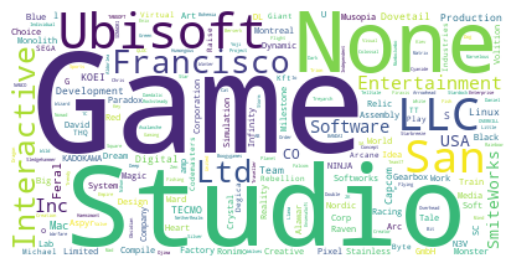

In [168]:
from wordcloud import WordCloud

word_cloud2 = WordCloud(collocations=False, background_color='white').generate("\n".join(df_games['developer'].astype('str')))

plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# %pip install wordcloud
# %pip install plotly